In [100]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 

import data_utils as data_utils
# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

dataset = pd.read_csv("datasets/dataset_clean.csv")
display(dataset.head(n = 5))

labels_raw = dataset[['RIESGO_VIDA']]
features_raw = dataset.drop(['RIESGO_VIDA'], axis = 1)

/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,15,18,19,20,21,22,23,24,26,28,29,30,31,33,34,35,36,37,38,39,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PET_COD_DEPTO,PET_DPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,RIESGO_VIDA,TRIM
0,bogota d.c.,de 13 a 17 años,ninguno,mujer,no aplica,bogotá,otro,no aplica,subsidiado,natural,...,11,bogota d.c.,bogotá,juridica,escrito,pqr,peticion directa,reclamo,0,trim i
1,nariño,de 0 a 5 años,ninguno,hombre,no aplica,puerres,otro,no aplica,subsidiado,natural,...,52,nariño,puerres,natural,telefonico,pqr,0,reclamo,0,trim i
2,valle,de 13 a 17 años,secundaria,hombre,no aplica,cali,abuelo (a),no aplica,contributivo,natural,...,76,valle,cali,natural,telefonico,pqr,0,reclamo,0,trim i
3,huila,de 13 a 17 años,universitario incompleto,hombre,no aplica,neiva,padre,no aplica,contributivo,natural,...,41,huila,neiva,natural,personalizado,pqr,0,reclamo,0,trim i
4,risaralda,de 13 a 17 años,ninguno,hombre,no aplica,dosquebradas,padre,persona en condición de discapacidad,contributivo,natural,...,66,risaralda,dosquebradas,natural,personalizado,pqr,0,reclamo,1,trim i


# Data Exploration

## Features Class Distribution

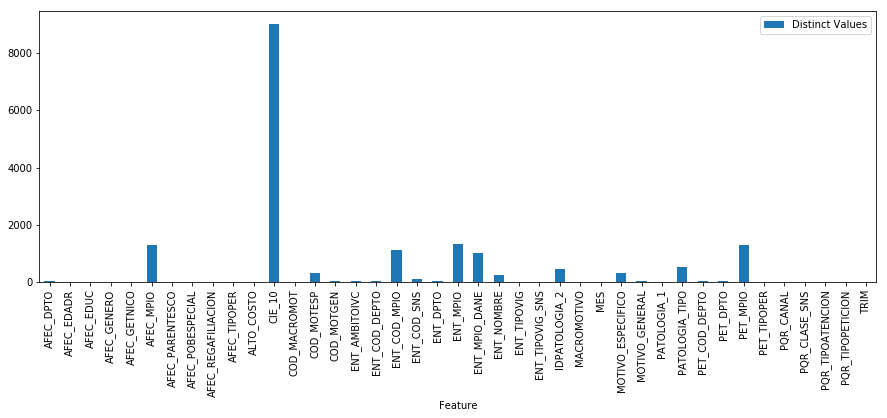

In [101]:
data_utils.showFeaturesDistribution(data_utils.getFeaturesDistribution(features_raw))


## Redundant features

These features represent the same data, so we can keep only the codes and loose the descripion.

* COD_MACROMOT = MACROMOTIVO
* COD_MOTGEN = MOTIVO_GENERAL
* COD_MOTESP = MOTIVO_ESPECIFICO
* ENT_COD_DEPTO = ENT_DPTO
* ENT_COD_MPIO = ENT_MPIO
* PET_COD_DEPTO = PET_DPTO

In [102]:
features_raw = features_raw.drop(['ENT_DPTO', 'ENT_MPIO', 'PET_DPTO', 'MACROMOTIVO', 'MOTIVO_GENERAL', 'MOTIVO_ESPECIFICO'], axis = 1)
features_raw = features_raw.applymap(str)

In [103]:
from __future__ import division
# TODO: Total number of records
n_records = dataset['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is at risk
life_risk = dataset[dataset["RIESGO_VIDA"] == 1]
n_life_risk = life_risk['RIESGO_VIDA'].count()

# TODO: Number of records where individual's life is not at risk
no_life_risk =  dataset[dataset["RIESGO_VIDA"] == 0]
n_no_life_risk = no_life_risk['RIESGO_VIDA'].count()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_life_risk/n_records)*100

# Print the results
print "Total number of records: {:,}".format(n_records)
print "Individuals with life at risk: {:,}".format(n_life_risk)
print "Individuals with life not at risk: {:,}".format(n_no_life_risk)
print "Percentage of individuals with life at risk: {:.2f}%".format(greater_percent)

Total number of records: 2,375,371
Individuals with life at risk: 288,811
Individuals with life not at risk: 2,086,560
Percentage of individuals with life at risk: 12.16%


## Encoding dataset

All features in the dataset are categorical. Some of them have too many classes to be one hot encoded. Mean encoding transformation will be perform on the dataset to encode features.

In [104]:
features_columns = features_raw.columns.values.tolist()

--- 2335.0015738 seconds ---


,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_1,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM
0,0.172465,0.262627,0.179425,0.187490,0.217272,0.171278,0.264173,0.204179,0.280688,0.200446,...,0.151759,0.151759,0.122722,0.175819,0.101865,0.074075,0.240487,0.081491,0.2386,0.131762
1,0.199864,0.278952,0.179425,0.219439,0.217272,0.163793,0.264173,0.204179,0.280688,0.200446,...,0.151759,0.151759,0.146529,0.106796,0.138643,0.084191,0.240487,0.139877,0.2386,0.131762
2,0.221915,0.262627,0.210089,0.219439,0.217272,0.217327,0.319044,0.204179,0.178150,0.200446,...,0.151759,0.151759,0.144960,0.149912,0.138643,0.084191,0.240487,0.139877,0.2386,0.131762
3,0.299221,0.262627,0.315311,0.219439,0.217272,0.334056,0.308624,0.204179,0.178150,0.200446,...,0.151759,0.151759,0.234090,0.261161,0.138643,0.466574,0.240487,0.139877,0.2386,0.131762
4,0.208638,0.262627,0.179425,0.219439,0.217272,0.217398,0.308624,0.386519,0.178150,0.200446,...,0.404018,0.404018,0.151495,0.164382,0.138643,0.466574,0.240487,0.139877,0.2386,0.131762


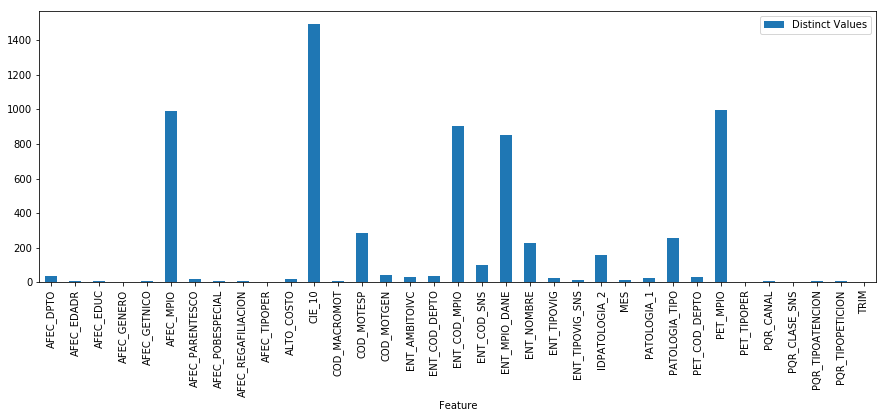

In [105]:
from category_encoders import *
import time


start_time = time.time()   
enc = TargetEncoder(cols=features_raw.columns.values.tolist(), return_df = True).fit(features_raw, labels_raw)
dataset_encoded = enc.transform(features_raw)
print("--- %s seconds ---" % (time.time() - start_time))

display(dataset_encoded.head(n = 5))  

showFeaturesDistribution(getFeaturesDistribution(dataset_encoded))

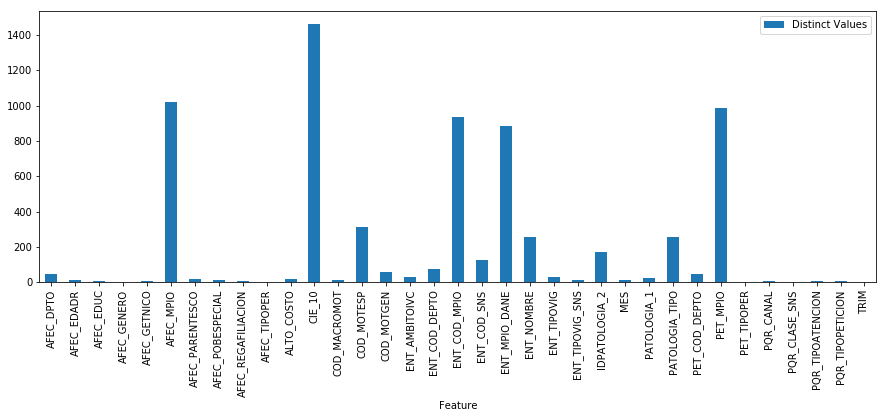

In [106]:

# Normalization with QuantileTransformer
from sklearn.preprocessing import QuantileTransformer

# Initialize a scaler, then apply it to the features
#scaler = QuantileTransformer() # default=(0, 1)
scaler = QuantileTransformer()

features_log_minmax_transform = pd.DataFrame(data = dataset_encoded)
features_log_minmax_transform[features_columns] = scaler.fit_transform(dataset_encoded[features_columns])

#distribution(features_log_minmax_transform, transformed = True)
# Show an example of a record with scaling applied
showFeaturesDistribution(getFeaturesDistribution(features_log_minmax_transform))

In [107]:
display(features_log_minmax_transform.head(n = 5))

,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_1,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM
0,0.623624,0.849349,0.633634,0.573574,0.756757,0.592092,0.872372,0.737237,1.000000,1.0,...,0.631632,0.646647,0.460961,0.842342,0.130631,0.139640,1.0,0.153654,0.744244,0.485485
1,0.758759,0.873874,0.633634,1.000000,0.756757,0.517607,0.872372,0.737237,1.000000,1.0,...,0.631632,0.646647,0.733734,0.467961,1.000000,0.639139,1.0,1.000000,0.744244,0.485485
2,0.875375,0.849349,0.810811,1.000000,0.756757,0.842843,0.927427,0.737237,0.617618,1.0,...,0.631632,0.646647,0.660661,0.679680,1.000000,0.639139,1.0,1.000000,0.744244,0.485485
3,0.982482,0.849349,1.000000,1.000000,0.756757,0.981982,0.921421,0.737237,0.617618,1.0,...,0.631632,0.646647,0.983984,0.977477,1.000000,1.000000,1.0,1.000000,0.744244,0.485485
4,0.771271,0.849349,0.633634,1.000000,0.756757,0.872873,0.921421,0.980480,0.617618,1.0,...,0.966967,0.964464,0.791792,0.741241,1.000000,1.000000,1.0,1.000000,0.744244,0.485485


## Store processed dataset

In [108]:
features_log_minmax_transform['RIESGO_VIDA'] = dataset['RIESGO_VIDA']
features_log_minmax_transform.to_csv("datasets/dataset.csv", encoding='utf-8', index = False)

## Post Processing Exploration

The target feature RIESGO_VIDA still has low correlation weight inrelation with the other features, but nevertheless it has more relevance than the correlation analysis in the original dataset.

Specifically, the features more related with the target feature are the motive fields  (CODMACROMOT  (0.4),  CODMOTGEN  (0.4)  and  CODMOTESP(0.5)), these are features representing the reason on why the patient is raising the right of request.  

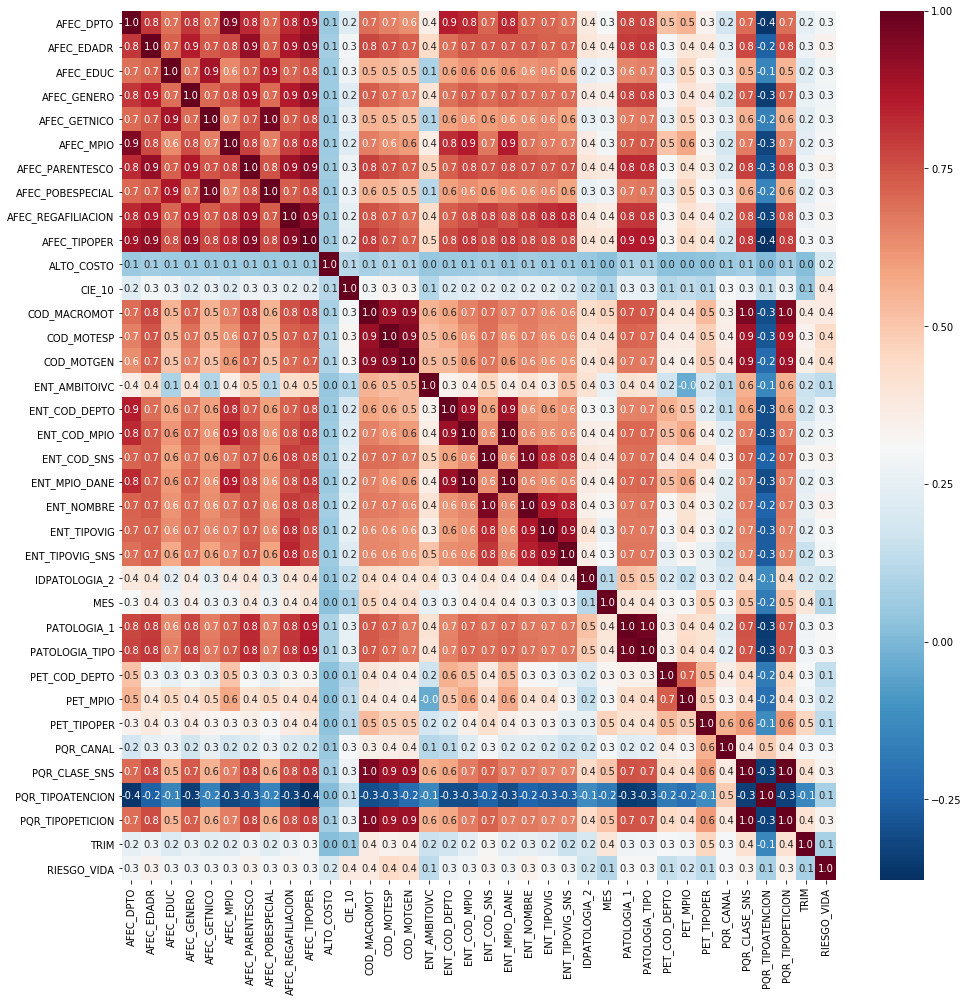

In [109]:
import seaborn as sns
plt.figure(figsize=(16, 16))

ax = sns.heatmap(features_log_minmax_transform.corr(), cmap = "RdBu_r", annot=True, fmt='.1f')